Hunter Bennett | Glass Lab | Kupffer Strains Project | 17 Feb 2023

Notebook to assess F1 H3K27Ac ChIP-seq data quality and assess for batch effects

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib_venn as venn
import seaborn as sns
from itertools import combinations, permutations
from scipy.stats import pearsonr

Set working directory 

In [2]:
workingDirectory = '/home/h1bennet/strains_github/results/Figure5_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


Define custom functions

In [3]:
def label_point(x, y, val, ax, fontsize=12, color='k', plot_points=False, pointsize=8, pointcolor='b'):
    '''This function makes it easier to overlay plotted points onto a matplotlib
    axes object. Allows for customization of fontsize and color and pointsize and
    point color.

        Accepts:
            x (int): list of x axis coordinates on plot
            y (int): list of y axis coordinates on plot
            val (str): list of text labels
            fontsize (int): size of fonts
            color (str): color of text
            plot_points (bool): whether to add points over text
            pointsize (int): size of points
            pointcolor (str): color of points
  
        Returns:
            None'''
 

    # import packages
    import matplotlib.pyplot as plt
    
    # plot over points
    if plot_points:
        for (xval, yval) in zip(x, y):
            ax.plot(xval, yval, markersize=pointsize, color=pointcolor)

    # plot over text
    for (xval, yval, text) in zip(x, y, val):
        ax.text(xval, yval, str(text), fontsize=fontsize)
        
def pca_rpkm_mat(rpkm, group_labels, n_pca=10, plot_size=8, legend=True):
    '''This function takes a pandas DF of rpkm values (genes x samples) with
    genes as the index and sample names as the column names and runs a simple
    PCA analysis.
    Accepts: 
    rpkm: gene x n_sample matrix of rpkm values
    group_labels: n_sample length array of group labels
    n_pca: number of principal components to analyze
    legend (bool): whether to plot legend
    Returns:
    tpm_pca_df: dataframe of principal components per each sample
    exp_var: array of explained variances for each PC
    '''
    
    # import packages
    import pandas as pd
    import numpy as np
    import seaborn as sns
    # Import packages for PCA analysis
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA # uses SVD
    
    # scale data
    tpm_std = StandardScaler().fit_transform(rpkm)
    # run PCA
    pca = PCA(n_components=n_pca)
    tpm_pca = pca.fit_transform(tpm_std.T)
    exp_var = pca.explained_variance_ratio_
    
    #create df for plotting
    tpm_pca_df = pd.DataFrame(tpm_pca,
                              columns=['PC'+str(i) for i in np.arange(1,tpm_pca.shape[1]+1)],
                              index=(group_labels))
    tpm_pca_df.index.rename('group', inplace=True)
    tpm_pca_df.reset_index(inplace=True)
    
    ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='group', # palette=color_dict,
                height=plot_size, scatter_kws={'s': 150},
                legend=legend)
    ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
    
    # return weights of each gene  
    transcript_pc = pd.DataFrame(pca.components_.T,
                                 rpkm.index,
                                 columns=['PC'+str(i) for i in np.arange(1,tpm_pca.shape[1]+1)])    

    return tpm_pca_df, exp_var, transcript_pc

def read_annotated_peaks(path, filter_sex_unknown=True):
    '''This function imports an annotated homer peak file using
    pandas read_csv function. It also performes common preprocessing steps
    such as placing the peak IDs in the index and filtering so that
    only autosomal peaks are included. Also renames index to peakID.
       
       Accepts:
           path (str): path to expression file
           filter_sex_unkown (bool): filter unknown chromosomes
           and sex chromosomes - focus analysis on autosomal chr.
       
       Returns:
           df (pandas.Dataframe): genes by samples with annotation.
           mat (pandas.DataFrame): genes by samples without annotation.
       '''
    # import functions
    import pandas as pd

    df = pd.read_csv(path, sep='\t', index_col=0)

    # rename index
    df.index.rename('PeakID', inplace=True)
    # rename sample columns so they are shorter (can add .str.split('/').str[-1] to shorten even more
    df = df.rename(
        columns=dict(zip(df.iloc[:, 18:].columns.values,
                         pd.Series(df.iloc[:, 18:].columns.values).str.split(' Tag Count').str[0])))

    
    # filter unknown and sex chromosomes
    autosomes = ['chr1', 'chr2', 'chr3', 'chr4',
                 'chr5', 'chr6', 'chr7', 'chr8',
                 'chr9', 'chr10', 'chr11', 'chr12',
                 'chr13', 'chr14', 'chr15', 'chr16',
                 'chr17', 'chr18', 'chr19']

    df = df.loc[df.Chr.str.contains('|'.join(autosomes)), :]
      
    mat = df.iloc[:, 18:]
        
    return (df, mat)

In [4]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['savefig.dpi'] = 500

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8

Import annotated peak files

In [5]:
df = pd.read_csv('https://zenodo.org/record/7829622/files/f1_idr_peaks_h3k27ac_norm.txt', sep='\t', index_col=0)
df.to_csv('./f1_idr_peaks_h3k27ac_norm.txt', sep='\t')

df = pd.read_csv('https://zenodo.org/record/7829622/files/f1_idr_peaks_h3k27ac_raw.txt', sep='\t', index_col=0)
df.to_csv('./f1_idr_peaks_h3k27ac_raw.txt', sep='\t')

# Descriptive analysis of data quality
1. Mean variance plot
2. Principal component analysis

Read in annotation files

In [7]:
# import annotation file
df, mat = read_annotated_peaks('./f1_idr_peaks_h3k27ac_norm.txt')

Lets start by looking at the peak intensity distribution for each sample.

In [8]:
greps = ['.*tag_perfect_mm10',
         '.*tag_perfect_balbcj',
         '.*only_muts_mm10',
         '.*only_muts_balbcj']

labels = ['C57BL6J Tag Perfect',
          'BALBcJ Tag Perfect',
          'C57BL6J Mutation Spanning',
          'BALBcJ Mutation Spanning']

colors = ['#31a354',
          '#3182bd',
          '#006d2c',
          '#08519c']

n_bins=20
transparency=0.6

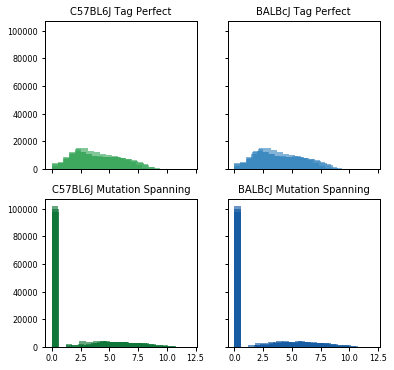

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(6,6),
                        sharex=True,
                        sharey=True)
# plt.subplots_adjust(hspace=0.4, wspace=0.4)

for grep, label, color, ax in zip(greps, labels, colors, axs.flat):
    
    for col in mat.columns[mat.columns.str.contains(grep)]:
        ax.hist(np.log2(mat.loc[:, col]+1),
                bins=n_bins,
                histtype='bar',
                color=color,
                alpha=transparency);
        ax.set_title(label, fontsize=10)

Zeros appear to dominate the above plot so lets try while filtering out peaks with less than 4 tag counts

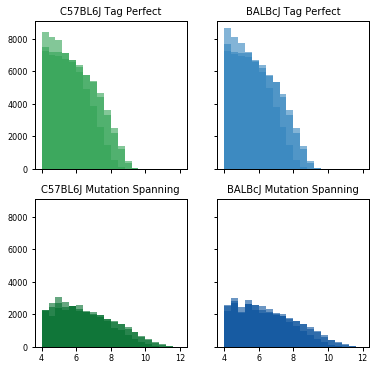

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(6,6),
                        sharex=True,
                        sharey=True)
# plt.subplots_adjust(hspace=0.4, wspace=0.4)

for grep, label, color, ax in zip(greps, labels, colors, axs.flat):
    
    for col in mat.columns[mat.columns.str.contains(grep)]:
        ax.hist(np.log2(mat.loc[:, col]+1),
                bins=n_bins,
                histtype='bar',
                color=color,
                alpha=transparency,
                range=[4,12]);
        ax.set_title(label, fontsize=10)

### How do they look when plotted in a pairwise fashion?

Text(0.5,1,'Mutation Spanning')

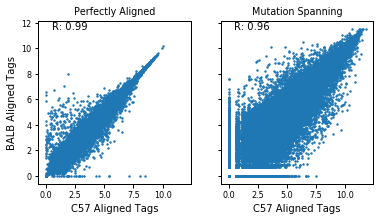

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(6,3),
                        sharex=True,
                        sharey=True)

axs[0].scatter(np.log2(mat.loc[:, mat.columns.str.contains('.*tag_perfect_mm10')].mean(1)+1),
               np.log2(mat.loc[:, mat.columns.str.contains('.*tag_perfect_balbcj')].mean(1)+1),
               s=2,
               rasterized=True)

axs[0].text(0.5,11.5, 'R: %.2f' % pearsonr(
    np.log2(mat.loc[:, mat.columns.str.contains('.*tag_perfect_mm10')].mean(1)+1),
    np.log2(mat.loc[:, mat.columns.str.contains('.*tag_perfect_balbcj')].mean(1)+1))[0],
    fontsize=10)

axs[0].set_xlabel('C57 Aligned Tags')
axs[0].set_ylabel('BALB Aligned Tags')
axs[0].set_title('Perfectly Aligned')

axs[1].scatter(np.log2(mat.loc[:, mat.columns.str.contains('.*only_muts_mm10')].mean(1)+1),
               np.log2(mat.loc[:, mat.columns.str.contains('.*only_muts_balbcj')].mean(1)+1),
               s=2,
               rasterized=True)

axs[1].text(0.5,11.5, 'R: %.2f' % pearsonr(
    np.log2(mat.loc[:, mat.columns.str.contains('.*only_muts_mm10')].mean(1)+1),
    np.log2(mat.loc[:, mat.columns.str.contains('.*only_muts_balbcj')].mean(1)+1))[0],
    fontsize=10)

axs[1].set_xlabel('C57 Aligned Tags')
# axs[1].set_ylabel('BALB Aligned Tags')
axs[1].set_title('Mutation Spanning')


# Simple PCA

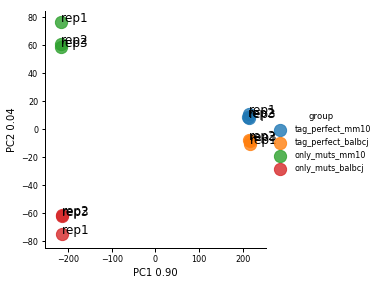

In [12]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=mat.columns.str[36:],
                                 plot_size=4,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            mat.columns.str[31:35],
            plt.gca())